<a href="https://colab.research.google.com/github/Karishmaraina/StockTrading/blob/main/qrsac_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FINRL

In [ ]:
!apt install swig
!pip install wrds

!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [ ]:


# Commented out IPython magic to ensure Python compatibility.
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

# %matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

TRAIN_START_DATE = '2020-01-01'
TRAIN_END_DATE = '2022-12-31'
# TRADE_START_DATE = '2022-01-01'
# TRADE_END_DATE = '2022-12-31'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

print(config_tickers.DOW_30_TICKER)

df.sort_values(['date','tic'],ignore_index=True).head()

fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

train.tail()

trade.head()

INDICATORS

stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


# e_train_gym = StockTradingEnv(df = train, **env_kwargs)

# env_train, _ = e_train_gym.get_sb_env()
# print(type(env_train))

from __future__ import annotations

from typing import List

import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gym import spaces
from gym.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv

matplotlib.use("Agg")

# from stable_baselines3.common.logger import Logger, KVWriter, CSVOutputFormat

def action_dim(space):
    """The dimension of action assuming that the action is flatten."""
    if isinstance(space, gym.spaces.Box):
        return int(np.prod(space.shape))
    elif isinstance(space, gym.spaces.Discrete):
        return int(space.n)
    else:
        raise ValueError
def get_space_shape(space: gym.spaces.Space) -> Tuple[int, ...]:
    if isinstance(space, gym.spaces.Box):
        return tuple(space.shape)
    elif isinstance(space, gym.spaces.Discrete):
        return (1, )
    else:
        raise ValueError

def state_shape(space):
        """The shape of observation space."""
        if isinstance(self.observation_space, gym.spaces.Tuple):
            return tuple(map(get_space_shape, self.observation_space))
        else:
            return get_space_shape(self.observation_space)


DummyVecEnv.action_dim=action_dim
DummyVecEnv.state_shape=state_shape

class StockEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df: pd.DataFrame,
        stock_dim: int,
        hmax: int,
        initial_amount: int,
        num_stock_shares: list[int],
        buy_cost_pct: list[float],
        sell_cost_pct: list[float],
        reward_scaling: float,
        state_space: int,
        action_space: int,
        tech_indicator_list: list[str],
        turbulence_threshold=None,
        risk_indicator_col="turbulence",
        make_plots: bool = False,
        print_verbosity=10,
        day=0,
        initial=True,
        previous_state=[],
        model_name="",
        mode="",
        iteration="",
    ):
        super(StockEnv, self).__init__()
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.num_stock_shares = num_stock_shares
        self.initial_amount = initial_amount  # get the initial cash
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,), dtype=np.float64
        )
        self.data = self.df.loc[self.day, :]
        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.turbulence_threshold = turbulence_threshold
        self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        # initalize state
        self.state = self._initiate_state()

        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        # memorize all the total balance change
        self.asset_memory = [
            self.initial_amount
            + np.sum(
                np.array(self.num_stock_shares)
                * np.array(self.state[1 : 1 + self.stock_dim])
            )
        ]  # the initial total asset is calculated by cash + sum (num_share_stock_i * price_stock_i)
        self.rewards_memory = []
        self.actions_memory = []
        self.state_memory = (
            []
        )  # we need sometimes to preserve the state in the middle of trading process
        self.date_memory = [self._get_date()]
        #         self.logger = Logger('results',[CSVOutputFormat])
        # self.reset()
        self._seed()

    def _sell_stock(self, index, action):
        def _do_sell_normal():
            if (
                self.state[index + 2 * self.stock_dim + 1] != True
            ):  # check if the stock is able to sell, for simlicity we just add it in techical index
                # if self.state[index + 1] > 0: # if we use price<0 to denote a stock is unable to trade in that day, the total asset calculation may be wrong for the price is unreasonable
                # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                if self.state[index + self.stock_dim + 1] > 0:
                    # Sell only if current asset is > 0
                    sell_num_shares = min(
                        abs(action), self.state[index + self.stock_dim + 1]
                    )
                    sell_amount = (
                        self.state[index + 1]
                        * sell_num_shares
                        * (1 - self.sell_cost_pct[index])
                    )
                    # update balance
                    self.state[0] += sell_amount

                    self.state[index + self.stock_dim + 1] -= sell_num_shares
                    self.cost += (
                        self.state[index + 1]
                        * sell_num_shares
                        * self.sell_cost_pct[index]
                    )
                    self.trades += 1
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = 0

            return sell_num_shares

        # perform sell action based on the sign of the action
        if self.turbulence_threshold is not None:
            if self.turbulence >= self.turbulence_threshold:
                if self.state[index + 1] > 0:
                    # Sell only if the price is > 0 (no missing data in this particular date)
                    # if turbulence goes over threshold, just clear out all positions
                    if self.state[index + self.stock_dim + 1] > 0:
                        # Sell only if current asset is > 0
                        sell_num_shares = self.state[index + self.stock_dim + 1]
                        sell_amount = (
                            self.state[index + 1]
                            * sell_num_shares
                            * (1 - self.sell_cost_pct[index])
                        )
                        # update balance
                        self.state[0] += sell_amount
                        self.state[index + self.stock_dim + 1] = 0
                        self.cost += (
                            self.state[index + 1]
                            * sell_num_shares
                            * self.sell_cost_pct[index]
                        )
                        self.trades += 1
                    else:
                        sell_num_shares = 0
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = _do_sell_normal()
        else:
            sell_num_shares = _do_sell_normal()

        return sell_num_shares

    def _buy_stock(self, index, action):
        def _do_buy():
            if (
                self.state[index + 2 * self.stock_dim + 1] != True
            ):  # check if the stock is able to buy
                # if self.state[index + 1] >0:
                # Buy only if the price is > 0 (no missing data in this particular date)
                available_amount = self.state[0] // (
                    self.state[index + 1] * (1 + self.buy_cost_pct[index])
                )  # when buying stocks, we should consider the cost of trading when calculating available_amount, or we may be have cash<0
                # print('available_amount:{}'.format(available_amount))

                # update balance
                buy_num_shares = min(available_amount, action)
                buy_amount = (
                    self.state[index + 1]
                    * buy_num_shares
                    * (1 + self.buy_cost_pct[index])
                )
                self.state[0] -= buy_amount

                self.state[index + self.stock_dim + 1] += buy_num_shares

                self.cost += (
                    self.state[index + 1] * buy_num_shares * self.buy_cost_pct[index]
                )
                self.trades += 1
            else:
                buy_num_shares = 0

            return buy_num_shares

        # perform buy action based on the sign of the action
        if self.turbulence_threshold is None:
            buy_num_shares = _do_buy()
        else:
            if self.turbulence < self.turbulence_threshold:
                buy_num_shares = _do_buy()
            else:
                buy_num_shares = 0
                pass

        return buy_num_shares

    def _make_plot(self):
        plt.plot(self.asset_memory, "r")
        plt.savefig(f"results/account_value_trade_{self.episode}.png")
        plt.close()

    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique()) - 1
        if self.terminal:
            # print(f"Episode: {self.episode}")
            if self.make_plots:
                self._make_plot()
            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            df_total_value = pd.DataFrame(self.asset_memory)
            tot_reward = (
                self.state[0]
                + sum(
                    np.array(self.state[1 : (self.stock_dim + 1)])
                    * np.array(
                        self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                    )
                )
                - self.asset_memory[0]
            )  # initial_amount is only cash part of our initial asset
            df_total_value.columns = ["account_value"]
            df_total_value["date"] = self.date_memory
            df_total_value["daily_return"] = df_total_value["account_value"].pct_change(
                1
            )
            if df_total_value["daily_return"].std() != 0:
                sharpe = (
                    (252**0.5)
                    * df_total_value["daily_return"].mean()
                    / df_total_value["daily_return"].std()
                )
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ["account_rewards"]
            df_rewards["date"] = self.date_memory[:-1]
            # if self.episode % self.print_verbosity == 0:
            print(f"day: {self.day}, episode: {self.episode}")
            print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
            print(f"end_total_asset: {end_total_asset:0.2f}")
            print(f"total_reward: {tot_reward:0.2f}")
            print(f"total_cost: {self.cost:0.2f}")
            print(f"total_trades: {self.trades}")
            if df_total_value["daily_return"].std() != 0:
                print(f"Sharpe: {sharpe:0.3f}")
            print("=================================")

            # if (self.model_name != "") and (self.mode != ""):
            df_actions = self.save_action_memory()
            df_actions.to_csv(
                "results/actions_{}_{}_{}.csv".format(
                    self.mode, self.model_name, self.iteration
                )
            )
            df_total_value.to_csv(
                "results/account_value_{}_{}_{}.csv".format(
                    self.mode, self.model_name, self.iteration
                ),
                index=False,
            )
            df_rewards.to_csv(
                "results/account_rewards_{}_{}_{}.csv".format(
                    self.mode, self.model_name, self.iteration
                ),
                index=False,
            )
            plt.plot(self.asset_memory, "r")
            plt.savefig(
                "results/account_value_{}_{}_{}.png".format(
                    self.mode, self.model_name, self.iteration
                )
            )
            plt.close()

            # Add outputs to logger interface
            # logger.record("environment/portfolio_value", end_total_asset)
            # logger.record("environment/total_reward", tot_reward)
            # logger.record("environment/total_reward_pct", (tot_reward / (end_total_asset - tot_reward)) * 100)
            # logger.record("environment/total_cost", self.cost)
            # logger.record("environment/total_trades", self.trades)

            step_return = np.array([np.array(self.state), self.reward, self.terminal, {}])

            return step_return

        else:
            actions = actions * self.hmax  # actions initially is scaled between 0 to 1
            actions = actions.astype(
                int
            )  # convert into integer because we can't by fraction of shares
            if self.turbulence_threshold is not None:
                if self.turbulence >= self.turbulence_threshold:
                    actions = np.array([-self.hmax] * self.stock_dim)
            begin_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            # print("begin_total_asset:{}".format(begin_total_asset))

            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][: np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print(f"Num shares before: {self.state[index+self.stock_dim+1]}")
                # print(f'take sell action before : {actions[index]}')
                actions[index] = self._sell_stock(index, actions[index]) * (-1)
                # print(f'take sell action after : {actions[index]}')
                # print(f"Num shares after: {self.state[index+self.stock_dim+1]}")

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                actions[index] = self._buy_stock(index, actions[index])

            self.actions_memory.append(actions)

            # state: s -> s+1
            self.day += 1
            self.data = self.df.loc[self.day, :]
            if self.turbulence_threshold is not None:
                if len(self.df.tic.unique()) == 1:
                    self.turbulence = self.data[self.risk_indicator_col]
                elif len(self.df.tic.unique()) > 1:
                    self.turbulence = self.data[self.risk_indicator_col].values[0]
            self.state = self._update_state()

            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            self.reward = end_total_asset - begin_total_asset
            self.rewards_memory.append(self.reward)
            self.reward = self.reward * self.reward_scaling
            self.state_memory.append(
                self.state
            )  # add current state in state_recorder for each step

        step_return = np.array([np.array(self.state), self.reward, self.terminal, {}])

        return step_return

    def reset(self):
        # initiate state
        self.state = self._initiate_state()

        if self.initial:
            self.asset_memory = [
                self.initial_amount
                + np.sum(
                    np.array(self.num_stock_shares)
                    * np.array(self.state[1 : 1 + self.stock_dim])
                )
            ]
        else:
            previous_total_asset = self.previous_state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(
                    self.previous_state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                )
            )
            self.asset_memory = [previous_total_asset]

        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        # self.iteration=self.iteration
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]

        self.episode += 1

        state = np.array(self.state)
        # state = spaces.Box(
        #     low=np.array(self.state), high=np.array(self.state)
        # )

        return state

    def render(self, mode="human", close=False):
        return self.state

    def _initiate_state(self):
        if self.initial:
            # For Initial State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.initial_amount]
                    + self.data.close.values.tolist()
                    + self.num_stock_shares
                    + sum(
                        (
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ),
                        [],
                    )
                )  # append initial stocks_share to initial state, instead of all zero
            else:
                # for single stock
                state = (
                    [self.initial_amount]
                    + [self.data.close]
                    + [0] * self.stock_dim
                    + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
                )
        else:
            # Using Previous State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.previous_state[0]]
                    + self.data.close.values.tolist()
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(
                        (
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ),
                        [],
                    )
                )
            else:
                # for single stock
                state = (
                    [self.previous_state[0]]
                    + [self.data.close]
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
                )
        return state

    def _update_state(self):
        if len(self.df.tic.unique()) > 1:
            # for multiple stock
            state = (
                [self.state[0]]
                + self.data.close.values.tolist()
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(
                    (
                        self.data[tech].values.tolist()
                        for tech in self.tech_indicator_list
                    ),
                    [],
                )
            )

        else:
            # for single stock
            state = (
                [self.state[0]]
                + [self.data.close]
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
            )

        return state

    def _get_date(self):
        if len(self.df.tic.unique()) > 1:
            date = self.data.date.unique()[0]
        else:
            date = self.data.date
        return date

    # add save_state_memory to preserve state in the trading process
    def save_state_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            state_list = self.state_memory
            df_states = pd.DataFrame(
                state_list,
                columns=[
                    "cash",
                    "Bitcoin_price",
                    "Gold_price",
                    "Bitcoin_num",
                    "Gold_num",
                    "Bitcoin_Disable",
                    "Gold_Disable",
                ],
            )
            df_states.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            state_list = self.state_memory
            df_states = pd.DataFrame({"date": date_list, "states": state_list})
        # print(df_states)
        return df_states

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        # print(len(date_list))
        # print(len(asset_list))
        df_account_value = pd.DataFrame(
            {"date": date_list, "account_value": asset_list}
        )
        return df_account_value

    def save_action_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = self.actions_memory
            df_actions = pd.DataFrame(action_list)
            df_actions.columns = self.data.tic.values
            df_actions.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            action_list = self.actions_memory
            df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs


/usr/local/lib/python3.10/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

# QRSAC

In [ ]:
stock_env = StockEnv(df = train, **env_kwargs, model_name="qrsac")

In [ ]:
!pip install --upgrade numpy==1.23.5
# restart here"

In [ ]:
!rm -rf /content/nnabla-rl

In [ ]:
!pip install nnabla-rl

!pip install "setuptools<58.0.0"

# !pip install stable_baselines3

  Using cached protobuf-3.19.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.23.4
    Uninstalling protobuf-4.23.4:
      Successfully uninstalled protobuf-4.23.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 2.11.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0.dev0,>=3.19.5, but you have protobuf 3.19.4 which is incompatible.
google-cloud-bigquery 3.10.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.19.4 which is incompatible.
google-cloud-bigquery-connection 1.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.19.4 which is 

  Using cached setuptools-57.5.0-py3-none-any.whl (819 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 68.0.0
    Uninstalling setuptools-68.0.0:
      Successfully uninstalled setuptools-68.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.15.1 requires setuptools>=60.0.0, but you have setuptools 57.5.0 which is incompatible.
ccxt 3.1.60 requires setuptools>=60.9.0, but you have setuptools 57.5.0 which is incompatible.
cvxpy 1.3.2 requires setuptools>65.5.1, but you have setuptools 57.5.0 which is incompatible.
tensorboard 2.12.3 requires protobuf>=3.19.6, but you have protobuf 3.19.4 which is incompatible.
tensorflow 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.19.4 which is incompatible.


In [ ]:
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Union

import gym

import nnabla as nn
import nnabla.solvers as NS
import nnabla_rl.environment_explorers as EE
import nnabla_rl.model_trainers as MT
from nnabla_rl.algorithm import Algorithm, AlgorithmConfig, eval_api
from nnabla_rl.algorithms.common_utils import _StochasticPolicyActionSelector
from nnabla_rl.builders import ExplorerBuilder, ModelBuilder, ReplayBufferBuilder, SolverBuilder
from nnabla_rl.environment_explorer import EnvironmentExplorer
from nnabla_rl.environments.environment_info import EnvironmentInfo
from nnabla_rl.model_trainers.model_trainer import ModelTrainer, TrainingBatch
from nnabla_rl.models import (QRSACQuantileDistributionFunction, QuantileDistributionFunction, SACPolicy,
                              StochasticPolicy)
from nnabla_rl.replay_buffer import ReplayBuffer
from nnabla_rl.utils import context
from nnabla_rl.utils.data import marshal_experiences
from nnabla_rl.utils.misc import sync_model

In [ ]:
@dataclass
class QRSACConfig(AlgorithmConfig):
    """QRSACConfig List of configurations for QRSAC algorithm.

    Args:
        gamma (float): discount factor of rewards. Defaults to 0.99.
        learning_rate (float): learning rate which is set to all solvers. \
            You can customize/override the learning rate for each solver by implementing the \
            (:py:class:`SolverBuilder <nnabla_rl.builders.SolverBuilder>`) by yourself. \
            Defaults to 0.0003.
        batch_size(int): training batch size. Defaults to 256.
        tau (float): target network's parameter update coefficient. Defaults to 0.005.
        environment_steps (int): Number of steps to interact with the environment on each iteration. Defaults to 1.
        gradient_steps (int): Number of parameter updates to perform on each iteration. Defaults to 1.
        target_entropy (float, optional): Target entropy value. Defaults to None.
        initial_temperature (float, optional): Initial value of temperature parameter. Defaults to None.
        fix_temperature (bool): If true the temperature parameter will not be trained. Defaults to False.
        start_timesteps (int): the timestep when training starts.\
            The algorithm will collect experiences from the environment by acting randomly until this timestep.\
            Defaults to 10000.
        replay_buffer_size (int): capacity of the replay buffer. Defaults to 1000000.
        num_steps (int): number of steps for N-step Q targets. Defaults to 1.
        num_quantiles (int): Number of quantile points. Defaults to 32.
        kappa (float): threshold value of quantile huber loss. Defaults to 1.0.
        actor_unroll_steps (int): Number of steps to unroll actor's tranining network.\
            The network will be unrolled even though the provided model doesn't have RNN layers.\
            Defaults to 1.
        actor_burn_in_steps (int): Number of burn-in steps to initiaze actor's recurrent layer states during training.\
            This flag does not take effect if given model is not an RNN model.\
            Defaults to 0.
        actor_reset_rnn_on_terminal (bool): Reset actor's recurrent internal states to zero during training\
            if episode ends. This flag does not take effect if given model is not an RNN model.\
            Defaults to False.
        critic_unroll_steps (int): Number of steps to unroll critic's tranining network.\
            The network will be unrolled even though the provided model doesn't have RNN layers.\
            Defaults to 1.
        critic_burn_in_steps (int): Number of burn-in steps to initiaze critic's recurrent layer states\
            during training. This flag does not take effect if given model is not an RNN model.\
            Defaults to 0.
        critic_reset_rnn_on_terminal (bool): Reset critic's recurrent internal states to zero during training\
            if episode ends. This flag does not take effect if given model is not an RNN model.\
            Defaults to False.
    """

    gamma: float = 0.99
    learning_rate: float = 3.0*1e-4
    batch_size: int = 256
    tau: float = 0.005
    environment_steps: int = 1
    gradient_steps: int = 1
    target_entropy: Optional[float] = None
    initial_temperature: Optional[float] = None
    fix_temperature: bool = False
    start_timesteps: int = 10000
    replay_buffer_size: int = 1000000
    num_steps: int = 1

    # Quantile function settings
    num_quantiles: int = 32
    kappa: float = 1.0

    # rnn model support
    actor_unroll_steps: int = 1
    actor_burn_in_steps: int = 0
    actor_reset_rnn_on_terminal: bool = True

    critic_unroll_steps: int = 1
    critic_burn_in_steps: int = 0
    critic_reset_rnn_on_terminal: bool = True

    def __post_init__(self):
        """__post_init__ Check set values are in valid range."""
        self._assert_between(self.tau, 0.0, 1.0, 'tau')
        self._assert_between(self.gamma, 0.0, 1.0, 'gamma')
        self._assert_positive(self.gradient_steps, 'gradient_steps')
        self._assert_positive(self.environment_steps, 'environment_steps')
        if self.initial_temperature is not None:
            self._assert_positive(self.initial_temperature, 'initial_temperature')
        self._assert_positive(self.start_timesteps, 'start_timesteps')

        self._assert_positive(self.critic_unroll_steps, 'critic_unroll_steps')
        self._assert_positive_or_zero(self.critic_burn_in_steps, 'critic_burn_in_steps')
        self._assert_positive(self.actor_unroll_steps, 'actor_unroll_steps')
        self._assert_positive_or_zero(self.actor_burn_in_steps, 'actor_burn_in_steps')
        self._assert_positive(self.num_quantiles, 'num_quantiles')
        self._assert_positive(self.kappa, 'kappa')


class DefaultQuantileFunctionBuilder(ModelBuilder[QuantileDistributionFunction]):
    def build_model(self,  # type: ignore[override]
                    scope_name: str,
                    env_info: EnvironmentInfo,
                    algorithm_config: QRSACConfig,
                    **kwargs) -> QuantileDistributionFunction:
        return QRSACQuantileDistributionFunction(scope_name, n_quantile=algorithm_config.num_quantiles)


class DefaultPolicyBuilder(ModelBuilder[StochasticPolicy]):
    def build_model(self,  # type: ignore[override]
                    scope_name: str,
                    env_info: EnvironmentInfo,
                    algorithm_config: QRSACConfig,
                    **kwargs) -> StochasticPolicy:
        return SACPolicy(scope_name, env_info.action_dim)


class DefaultSolverBuilder(SolverBuilder):
    def build_solver(self,  # type: ignore[override]
                     env_info: EnvironmentInfo,
                     algorithm_config: QRSACConfig,
                     **kwargs) -> nn.solver.Solver:
        return NS.Adam(alpha=algorithm_config.learning_rate)


class DefaultReplayBufferBuilder(ReplayBufferBuilder):
    def build_replay_buffer(self,  # type: ignore[override]
                            env_info: EnvironmentInfo,
                            algorithm_config: QRSACConfig,
                            **kwargs) -> ReplayBuffer:
        return ReplayBuffer(capacity=algorithm_config.replay_buffer_size)


class DefaultExplorerBuilder(ExplorerBuilder):
    def build_explorer(self,  # type: ignore[override]
                       env_info: EnvironmentInfo,
                       algorithm_config: QRSACConfig,
                       algorithm: "QRSAC",
                       **kwargs) -> EnvironmentExplorer:
        explorer_config = EE.RawPolicyExplorerConfig(
            warmup_random_steps=algorithm_config.start_timesteps,
            initial_step_num=algorithm.iteration_num,
            timelimit_as_terminal=False
        )
        explorer = EE.RawPolicyExplorer(policy_action_selector=algorithm._exploration_action_selector,
                                        env_info=env_info,
                                        config=explorer_config)
        return explorer

In [ ]:
class QRSAC(Algorithm):

    # type declarations to type check with mypy
    # NOTE: declared variables are instance variable and NOT class variable, unless it is marked with ClassVar
    # See https://mypy.readthedocs.io/en/stable/class_basics.html for details
    _config: QRSACConfig
    _q1: QuantileDistributionFunction
    _q2: QuantileDistributionFunction
    _train_q_functions: List[QuantileDistributionFunction]
    _train_q_solvers: Dict[str, nn.solver.Solver]
    _target_q_functions: List[QuantileDistributionFunction]

    _pi: StochasticPolicy
    _temperature: MT.policy_trainers.soft_policy_trainer.AdjustableTemperature
    _temperature_solver: Optional[nn.solver.Solver]
    _replay_buffer: ReplayBuffer

    _explorer_builder: ExplorerBuilder
    _environment_explorer: EnvironmentExplorer
    _policy_trainer: ModelTrainer
    _q_function_trainer: ModelTrainer

    _policy_trainer_state: Dict[str, Any]
    _quantile_function_trainer_state: Dict[str, Any]

    def __init__(self, env_or_env_info: Union[gym.Env, EnvironmentInfo],
                 config: QRSACConfig = QRSACConfig(),
                 quantile_function_builder: ModelBuilder[QuantileDistributionFunction]
                 = DefaultQuantileFunctionBuilder(),
                 quantile_solver_builder: SolverBuilder = DefaultSolverBuilder(),
                 policy_builder: ModelBuilder[StochasticPolicy] = DefaultPolicyBuilder(),
                 policy_solver_builder: SolverBuilder = DefaultSolverBuilder(),
                 temperature_solver_builder: SolverBuilder = DefaultSolverBuilder(),
                 replay_buffer_builder: ReplayBufferBuilder = DefaultReplayBufferBuilder(),
                 explorer_builder: ExplorerBuilder = DefaultExplorerBuilder()):
        super(QRSAC, self).__init__(env_or_env_info, config=config)

        self._explorer_builder = explorer_builder

        with nn.context_scope(context.get_nnabla_context(self._config.gpu_id)):
            self._q1 = quantile_function_builder(
                scope_name="q1", env_info=self._env_info, algorithm_config=self._config)
            self._q2 = quantile_function_builder(
                scope_name="q2", env_info=self._env_info, algorithm_config=self._config)
            self._train_q_functions = [self._q1, self._q2]
            self._train_q_solvers = {q.scope_name: quantile_solver_builder(self._env_info, self._config)
                                     for q in self._train_q_functions}
            self._target_q_functions = [q.deepcopy('target_' + q.scope_name) for q in self._train_q_functions]

            self._pi = policy_builder(scope_name="pi", env_info=self._env_info, algorithm_config=self._config)
            self._pi_solver = policy_solver_builder(self._env_info, self._config)

            self._temperature = MT.policy_trainers.soft_policy_trainer.AdjustableTemperature(
                scope_name='temperature',
                initial_value=self._config.initial_temperature)
            if not self._config.fix_temperature:
                self._temperature_solver = temperature_solver_builder(self._env_info, self._config)
            else:
                self._temperature_solver = None

            self._replay_buffer = replay_buffer_builder(self._env_info, self._config)

        self._evaluation_actor = _StochasticPolicyActionSelector(
            self._env_info, self._pi.shallowcopy(), deterministic=True)
        self._exploration_actor = _StochasticPolicyActionSelector(
            self._env_info, self._pi.shallowcopy(), deterministic=False)

    @eval_api
    def compute_eval_action(self, state, *, begin_of_episode=False, extra_info={}):
        with nn.context_scope(context.get_nnabla_context(self._config.gpu_id)):
            action, _ = self._evaluation_action_selector(state, begin_of_episode=begin_of_episode)
            return action

    def _before_training_start(self, env_or_buffer):
        # set context globally to ensure that the training runs on configured gpu
        context.set_nnabla_context(self._config.gpu_id)
        self._environment_explorer = self._setup_environment_explorer(env_or_buffer)
        self._policy_trainer = self._setup_policy_training(env_or_buffer)
        self._quantile_function_trainer = self._setup_quantile_function_training(env_or_buffer)

    def _setup_environment_explorer(self, env_or_buffer):
        return None if self._is_buffer(env_or_buffer) else self._explorer_builder(self._env_info, self._config, self)

    def _setup_policy_training(self, env_or_buffer):
        policy_trainer_config = MT.policy_trainers.SoftPolicyTrainerConfig(
            fixed_temperature=self._config.fix_temperature,
            target_entropy=self._config.target_entropy,
            unroll_steps=self._config.actor_unroll_steps,
            burn_in_steps=self._config.actor_burn_in_steps,
            reset_on_terminal=self._config.actor_reset_rnn_on_terminal)
        policy_trainer = MT.policy_trainers.SoftPolicyTrainer(
            models=self._pi,
            solvers={self._pi.scope_name: self._pi_solver},
            temperature=self._temperature,
            temperature_solver=self._temperature_solver,
            q_functions=[self._q1.as_q_function(), self._q2.as_q_function()],
            env_info=self._env_info,
            config=policy_trainer_config)
        return policy_trainer

    def _setup_quantile_function_training(self, env_or_buffer):
        # training input/loss variables
        quantile_function_trainer_config = MT.q_value_trainers.QRSACQTrainerConfig(
            kappa=self._config.kappa,
            num_quantiles=self._config.num_quantiles,
            num_steps=self._config.num_steps,
            unroll_steps=self._config.critic_unroll_steps,
            burn_in_steps=self._config.critic_burn_in_steps,
            reset_on_terminal=self._config.critic_reset_rnn_on_terminal)

        quantile_function_trainer = MT.q_value_trainers.QRSACQTrainer(
            train_functions=self._train_q_functions,
            solvers=self._train_q_solvers,
            target_functions=self._target_q_functions,
            target_policy=self._pi,
            temperature=self._policy_trainer.get_temperature(),
            env_info=self._env_info,
            config=quantile_function_trainer_config)
        for q, target_q in zip(self._train_q_functions, self._target_q_functions):
            sync_model(q, target_q)
        return quantile_function_trainer

    def _run_online_training_iteration(self, env):
        for _ in range(self._config.environment_steps):
            self._run_environment_step(env)
        for _ in range(self._config.gradient_steps):
            self._run_gradient_step(self._replay_buffer)

    def _run_offline_training_iteration(self, buffer):
        self._qrsac_training(buffer)

    def _run_environment_step(self, env):
        experiences = self._environment_explorer.step(env)
        self._replay_buffer.append_all(experiences)

    def _run_gradient_step(self, replay_buffer):
        if self._config.start_timesteps < self.iteration_num:
            self._qrsac_training(replay_buffer)

    def _qrsac_training(self, replay_buffer):
        actor_steps = self._config.actor_burn_in_steps + self._config.actor_unroll_steps
        critic_steps = self._config.num_steps + self._config.critic_burn_in_steps + self._config.critic_unroll_steps - 1
        num_steps = max(actor_steps, critic_steps)
        experiences_tuple, info = replay_buffer.sample(self._config.batch_size, num_steps=num_steps)
        if num_steps == 1:
            experiences_tuple = (experiences_tuple, )
        assert len(experiences_tuple) == num_steps

        batch = None
        for experiences in reversed(experiences_tuple):
            (s, a, r, non_terminal, s_next, rnn_states_dict, *_) = marshal_experiences(experiences)
            rnn_states = rnn_states_dict['rnn_states'] if 'rnn_states' in rnn_states_dict else {}
            batch = TrainingBatch(batch_size=self._config.batch_size,
                                  s_current=s,
                                  a_current=a,
                                  gamma=self._config.gamma,
                                  reward=r,
                                  non_terminal=non_terminal,
                                  s_next=s_next,
                                  weight=info['weights'],
                                  next_step_batch=batch,
                                  rnn_states=rnn_states)

        self._quantile_function_trainer_state = self._quantile_function_trainer.train(batch)
        for q, target_q in zip(self._train_q_functions, self._target_q_functions):
            sync_model(q, target_q, tau=self._config.tau)
        self._policy_trainer_state = self._policy_trainer.train(batch)

    def _evaluation_action_selector(self, s, *, begin_of_episode=False):
        return self._evaluation_actor(s, begin_of_episode=begin_of_episode)

    def _exploration_action_selector(self, s, *, begin_of_episode=False):
        return self._exploration_actor(s, begin_of_episode=begin_of_episode)

    def _models(self):
        models = [self._q1, self._q2, self._pi, self._temperature]
        return {model.scope_name: model for model in models}

    def _solvers(self):
        solvers = {}
        solvers[self._pi.scope_name] = self._pi_solver
        solvers.update(self._train_q_solvers)
        if self._temperature_solver is not None:
            solvers[self._temperature.scope_name] = self._temperature_solver
        return solvers

    @classmethod
    def is_rnn_supported(self):
        return True

    @classmethod
    def is_supported_env(cls, env_or_env_info):
        env_info = EnvironmentInfo.from_env(env_or_env_info) if isinstance(env_or_env_info, gym.Env) \
            else env_or_env_info
        return not env_info.is_discrete_action_env()

    @property
    def latest_iteration_state(self):
        latest_iteration_state = super().latest_iteration_state
        if hasattr(self, '_policy_trainer_state'):
            latest_iteration_state['scalar'].update({'pi_loss': float(self._policy_trainer_state['pi_loss'])})
        if hasattr(self, '_quantile_function_trainer_state'):
            latest_iteration_state['scalar'].update({'q_loss': float(self._quantile_function_trainer_state['q_loss'])})
        return latest_iteration_state

    @property
    def trainers(self):
        return {"q_function": self._quantile_function_trainer, "policy": self._policy_trainer}

In [ ]:
import nnabla_rl.hooks as H
import nnabla_rl.writers as W
from nnabla_rl.utils.evaluator import EpisodicEvaluator
from nnabla_rl.utils.reproductions import set_global_seed
from nnabla_rl.environments.wrappers import NumpyFloat32Env, ScreenRenderEnv

In [ ]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

insample_risk_indicator.vix.describe()

insample_risk_indicator.vix.quantile(0.996)

insample_risk_indicator.turbulence.describe()

insample_risk_indicator.turbulence.quantile(0.996)

config = QRSACConfig()

nn.clear_parameters()
qrsac = QRSAC(stock_env, config=config)
dir(qrsac)


import nnabla_rl.hooks as H
import nnabla_rl.writers as W
training_graph_hook = H.TrainingGraphHook(outdir="test_train")
evaluator = EpisodicEvaluator(run_per_evaluation=10)
evaluation_hook = H.EvaluationHook(
    stock_env,
    evaluator,
    timing=10,
    writer=W.MonitorWriter(outdir="test_trade", file_prefix='evaluation_result'),
)

qrsac.set_hooks([evaluation_hook])

import warnings
warnings.filterwarnings('ignore')

qrsac = QRSAC(stock_env, config=config)
qrsac.train(stock_env, total_iterations=20)

trained_qrsac = qrsac
dir(trained_qrsac)

# PPO

In [ ]:
stock_ppo_env = StockEnv(df = train, **env_kwargs, model_name="ppo")
agent = DRLAgent(env = stock_ppo_env)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)
trained_ppo = agent.train_model(model=model_ppo, tb_log_name='ppo', total_timesteps=50000)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
day: 481, episode: 1
begin_total_asset: 1000000.00
end_total_asset: 1056207.02
total_reward: 56207.02
total_cost: 95798.93
total_trades: 12914
Sharpe: 0.241
day: 481, episode: 2
begin_total_asset: 1000000.00
end_total_asset: 1002321.59
total_reward: 2321.59
total_cost: 94437.62
total_trades: 12876
Sharpe: 0.142
day: 481, episode: 3
begin_total_asset: 1000000.00
end_total_asset: 998324.98
total_reward: -1675.02
total_cost: 93846.63
total_trades: 12846
Sharpe: 0.132
day: 481, episode: 4
begin_total_asset: 1000000.00
end_total_asset: 1084280.49
total_reward: 84280.49
total_cost: 101601.10
total_trades: 13083
Sharpe: 0.292
-----------------------------------
| rollout/           |            |
|    ep_len_mean     | 482        |
|    ep_rew_mean     | 4.16       |
| time/              |            |
|    fps          

In [ ]:
stock_ddpg_env = StockEnv(df = train, **env_kwargs, model_name="ddpg")
ddpg_agent = DRLAgent(env = stock_ddpg_env)
model_ddpg = ddpg_agent.get_model("ddpg")
trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=50000)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
day: 481, episode: 1
begin_total_asset: 1000000.00
end_total_asset: 1085729.53
total_reward: 85729.53
total_cost: 16535.72
total_trades: 7727
Sharpe: 0.295
day: 481, episode: 2
begin_total_asset: 1000000.00
end_total_asset: 1113593.66
total_reward: 113593.66
total_cost: 998.98
total_trades: 9620
Sharpe: 0.341
day: 481, episode: 3
begin_total_asset: 1000000.00
end_total_asset: 1113593.66
total_reward: 113593.66
total_cost: 998.98
total_trades: 9620
Sharpe: 0.341
day: 481, episode: 4
begin_total_asset: 1000000.00
end_total_asset: 1113593.66
total_reward: 113593.66
total_cost: 998.98
total_trades: 9620
Sharpe: 0.341
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 482       |
|    ep_rew_mean     | 11.3      |
| time/              |           |
|    episodes        | 4         |
|    fps 

A2C

In [ ]:
stock_a2c_env = StockEnv(df = train, **env_kwargs, model_name="a2c")
a2c_agent = DRLAgent(env = stock_a2c_env)
model_a2c = a2c_agent.get_model("a2c")
trained_a2c = agent.train_model(model=model_a2c, tb_log_name='a2c', total_timesteps=50000)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
day: 481, episode: 1
begin_total_asset: 1000000.00
end_total_asset: 1285450.36
total_reward: 285450.36
total_cost: 49117.80
total_trades: 10731
Sharpe: 0.622
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 482       |
|    ep_rew_mean        | 28.4      |
| time/                 |           |
|    fps                | 198       |
|    iterations         | 100       |
|    time_elapsed       | 2         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -42.6     |
|    explained_variance | -0.0743   |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -18.7     |
|    reward             | 0.2576688 |
|    std                | 1         |
|    value_loss         | 0.253     |
------

# Results

In [ ]:
import pandas as pd


In [ ]:
rl_algo = ["a2c", "ddpg", "ppo", "qrsac"]

In [ ]:
rewards_df = {}
for algo in rl_algo:
  reward = pd.read_csv(f'/content/results/account_rewards__{algo}_.csv')
  rewards_df[algo] = reward
rewards_df["qrsac"].tail()

,account_rewards,date
476,9504.615849,2021-11-19
477,3664.198738,2021-11-22
478,1340.242237,2021-11-23
479,-22589.717640,2021-11-24
480,2806.642109,2021-11-26


In [ ]:
value_df = {}
for algo in rl_algo:
  value = pd.read_csv(f'/content/results/account_value__{algo}_.csv')
  value_df[algo] = value
value_df["qrsac"].tail()

,account_value,date,daily_return
477,1.230005e+06,2021-11-22,0.007787
478,1.233670e+06,2021-11-23,0.002979
479,1.235010e+06,2021-11-24,0.001086
480,1.212420e+06,2021-11-26,-0.018291
481,1.215227e+06,2021-11-29,0.002315


# Graphs

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

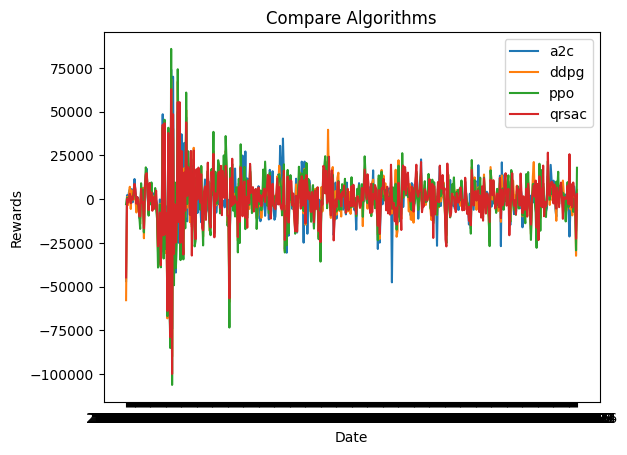

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.clf()
for algo in rl_algo:
  plt.plot(rewards_df[algo]["date"], rewards_df[algo]["account_rewards"], label = algo)

plt.xlabel('Date')
plt.ylabel('Rewards')
plt.title('Compare Algorithms')
plt.legend()
plt.show()
plt.savefig("results/rewards_compare.png")

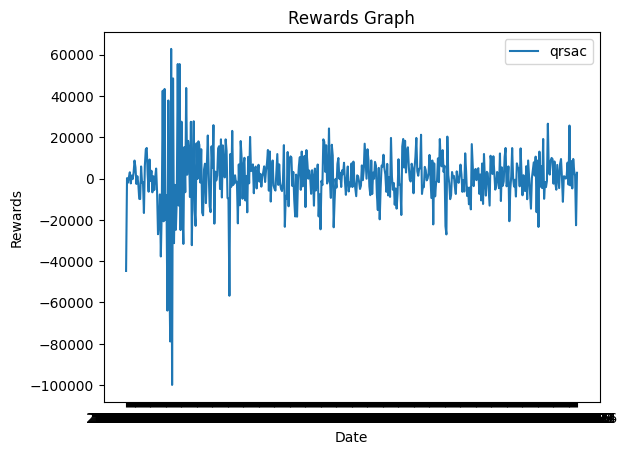

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.clf()
plt.plot(rewards_df["qrsac"]["date"], rewards_df["qrsac"]["account_rewards"], label = "qrsac")
plt.xlabel('Date')
plt.ylabel('Rewards')
plt.title('Rewards Graph')
plt.legend()
plt.show()
plt.savefig("results/rewards_qrsac.png")

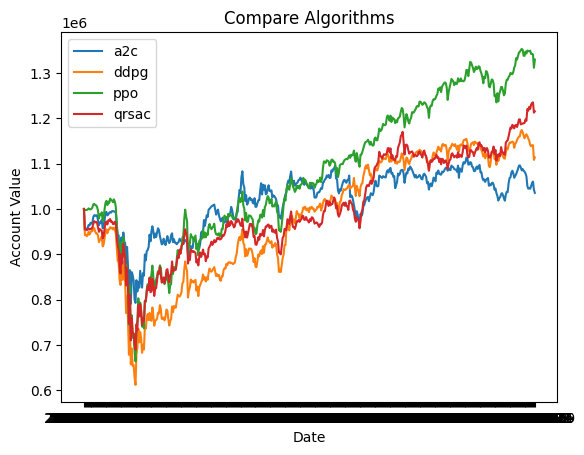

<Figure size 640x480 with 0 Axes>

In [ ]:
# Account Value
plt.clf()
for algo in rl_algo:
  plt.plot(value_df[algo]["date"], value_df[algo]["account_value"], label = algo)

plt.xlabel('Date')
plt.ylabel('Account Value')
plt.title('Compare Algorithms')
plt.legend()
plt.show()
plt.savefig("results/value_compare.png")